# Beautif.ai classification

The goal of your project is to create a robust classifier, to collect data and prepare custom dataset.  
You will build a model that will recognize 4 types of natural events in nature/indoor/outdoor:

* Daylight sky 
  * <img src = "https://ak.picdn.net/shutterstock/videos/7077064/thumb/1.jpg" width = "50%" height="50%">
* Sky at night
  * <img src="https://i.pinimg.com/originals/ec/98/dd/ec98dd97904e60661b1d545a88006e6a.jpg" width="50%" height="50%"/>

* Picture doesn't contain sky (no matter it's day or night)
  * <img src= "https://www.hotelsolun.com/application/files/5515/6285/1004/1X9A8812.jpg" width="50%" height="50%"/>


This project consists of the following activities :


1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about neural networks
    * Compose neural network architectures
    * Ping Pong phase with Dataset labelers
    * Generate syntethic data if needed
    * Fine tunning of your model
3. Phase 3 : Deployment
    * Analysis and benchmark Precision/Recall
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


# Load Data

In [ ]:
import os
from google.colab import drive
from PIL import Image
import shutil
import random
import cv2
from keras.applications.xception import preprocess_input as X_pre
from keras.applications.resnet50 import preprocess_input as Res_pre
import numpy as np

from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils
import cv2

import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet50
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

plt.style.use( "ggplot" )

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def split_test_valid( split_ratio, set_path, random_seed = 1, print_ratio = False, include_path = True ) :

    """
    This functions lists through a directory containing different sets in sorted subdirectories and returns test_x, valid_x, test_labels, valid_labels ( or x and y ) for further use.
    The arguments that need to be provided:
        split_ratio: is the ratio for the data set to be split along. Acceptable input is a float between 0 and 1 i.e. the percentage needed for further use; 
        set_path: is the path to the main directory where the subdirectories are located.
    Optional arguments:
         random_seed: is self-explanatory;
         print_ratio: prints the int ratio of the split.
         include_path: whether or not to include the full path in the train and test sets.
            If True returns: '/content/drive/MyDrive/Directory/Subdirectiory/Image.jpg';
            If False returns: 'Image.jpg'.
    """

    random.seed( random_seed )
    
    total = 0

    test_x = []
    valid_x = []
    test_labels = []
    valid_labels = []

    default_location = os.getcwd()

    if set_path[ -1 ] == "/" :
        set_path = set_path[0:-1]

    os.chdir( set_path )
    list_dir = os.listdir( set_path )

    for folder in list_dir :
        os.chdir( f'{ set_path}/{ folder }' )
        how_many =  len( os.listdir() )
        total += how_many

        test_set = int( round( how_many * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( how_many * split_ratio, 0 ) )

        nums = [ x for x in range( 1, how_many ) ]
        random_nums = random.sample( nums, valid_set )

        # The split itself :
        for ind, item in enumerate( os.listdir() ):

            if ind in random_nums :
                if include_path == True :
                    valid_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    valid_x.append( item )

                valid_labels.append( folder )

            if ind not in random_nums :

                if include_path == True :
                    test_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    test_x.append( item )

                test_labels.append( folder )

        if print_ratio == True :

            print( f"Set: { folder } - { how_many } items" )
            print( f"Train: { test_set }" )
            print( f"Validation: { valid_set }" )
            print( f"Total: { test_set + valid_set }" )
            print( "---------" )
        elif print_ratio == False :
            pass

    os.chdir( default_location )
    
    if print_ratio == True :
        test_set = int( round( total * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( total * split_ratio, 0 ) )

        print( "---------" ) 
        print( f"United set: { total } items" )
        print( f"Train: { test_set }" )
        print( f"Validation: { valid_set }" )
        print( f"Total: { test_set + valid_set }" )
        print( "---------" )
    elif print_ratio == False :
            pass

    return test_x, valid_x, test_labels, valid_labels

In [ ]:
set_path = "/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224"
split_ratio = 0.15

train_x, validation_x, train_labels, validation_labels  = split_test_valid( split_ratio, set_path, random_seed = 42, print_ratio = True )

Set: Night-Separated - 658 items
Train: 559
Validation: 99
Total: 658
---------
Set: No_Sky - 3792 items
Train: 3223
Validation: 569
Total: 3792
---------
Set: Day - 3303 items
Train: 2808
Validation: 495
Total: 3303
---------
Set: Night-Not_Separated - 887 items
Train: 754
Validation: 133
Total: 887
---------
---------
United set: 8640 items
Train: 7344
Validation: 1296
Total: 8640
---------


In [ ]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(train_labels)

LabelEncoder()

In [ ]:
train_targets = le.transform(train_labels)
val_targets = le.transform(validation_labels)

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
train_targets = np_utils.to_categorical(train_targets,num_classes=4)
val_targets = np_utils.to_categorical(val_targets,num_classes=4)

# Visualize Data Distribution

# Image Preprocessing

In [ ]:
def load_image( path ) :
  # READ AND PREPROCESS IMAGE HERE
  #cv2.imread
  image = cv2.imread( path ).astype( np.float32 )
  image_resized = Res_pre( image )
  return image_resized

def load_dataset( files ) :
  vector = []
  brojcanik = 0
  for file in files:
    brojcanik = brojcanik + 1
    vector.append( load_image( file ) )
    if brojcanik%100 == 0:
      print(f"procesirani se vkupno {brojcanik} sliki")
  return np.array( vector )


X_train = load_dataset( train_x )
X_val = load_dataset( validation_x )

procesirani se vkupno 100 sliki
procesirani se vkupno 200 sliki
procesirani se vkupno 300 sliki
procesirani se vkupno 400 sliki
procesirani se vkupno 500 sliki
procesirani se vkupno 600 sliki
procesirani se vkupno 700 sliki
procesirani se vkupno 800 sliki
procesirani se vkupno 900 sliki
procesirani se vkupno 1000 sliki
procesirani se vkupno 1100 sliki
procesirani se vkupno 1200 sliki
procesirani se vkupno 1300 sliki
procesirani se vkupno 1400 sliki
procesirani se vkupno 1500 sliki
procesirani se vkupno 1600 sliki
procesirani se vkupno 1700 sliki
procesirani se vkupno 1800 sliki
procesirani se vkupno 1900 sliki
procesirani se vkupno 2000 sliki
procesirani se vkupno 2100 sliki
procesirani se vkupno 2200 sliki
procesirani se vkupno 2300 sliki
procesirani se vkupno 2400 sliki
procesirani se vkupno 2500 sliki
procesirani se vkupno 2600 sliki
procesirani se vkupno 2700 sliki
procesirani se vkupno 2800 sliki
procesirani se vkupno 2900 sliki
procesirani se vkupno 3000 sliki
procesirani se vkup

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

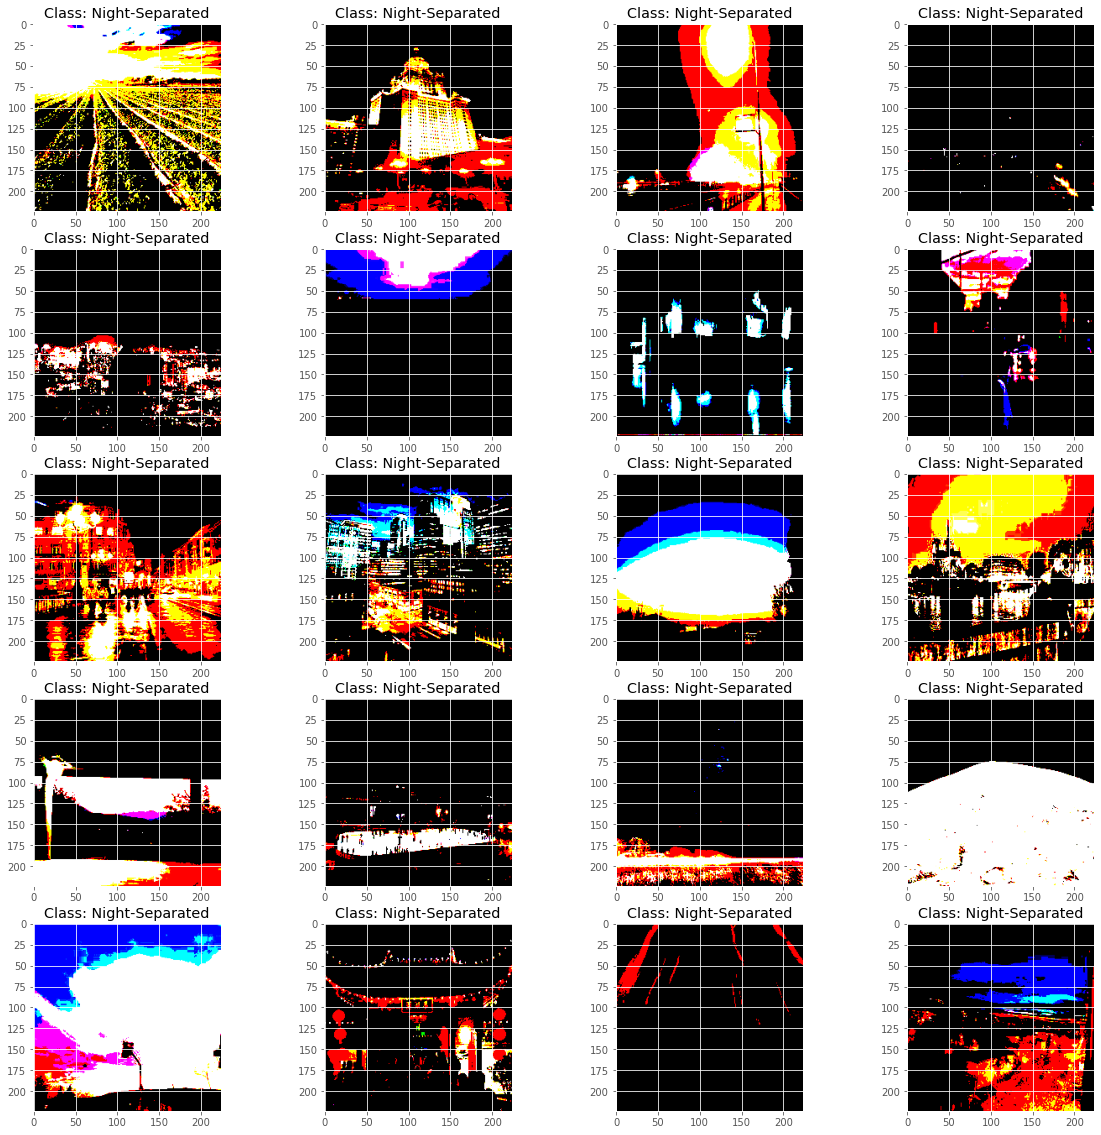

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_train[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + train_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

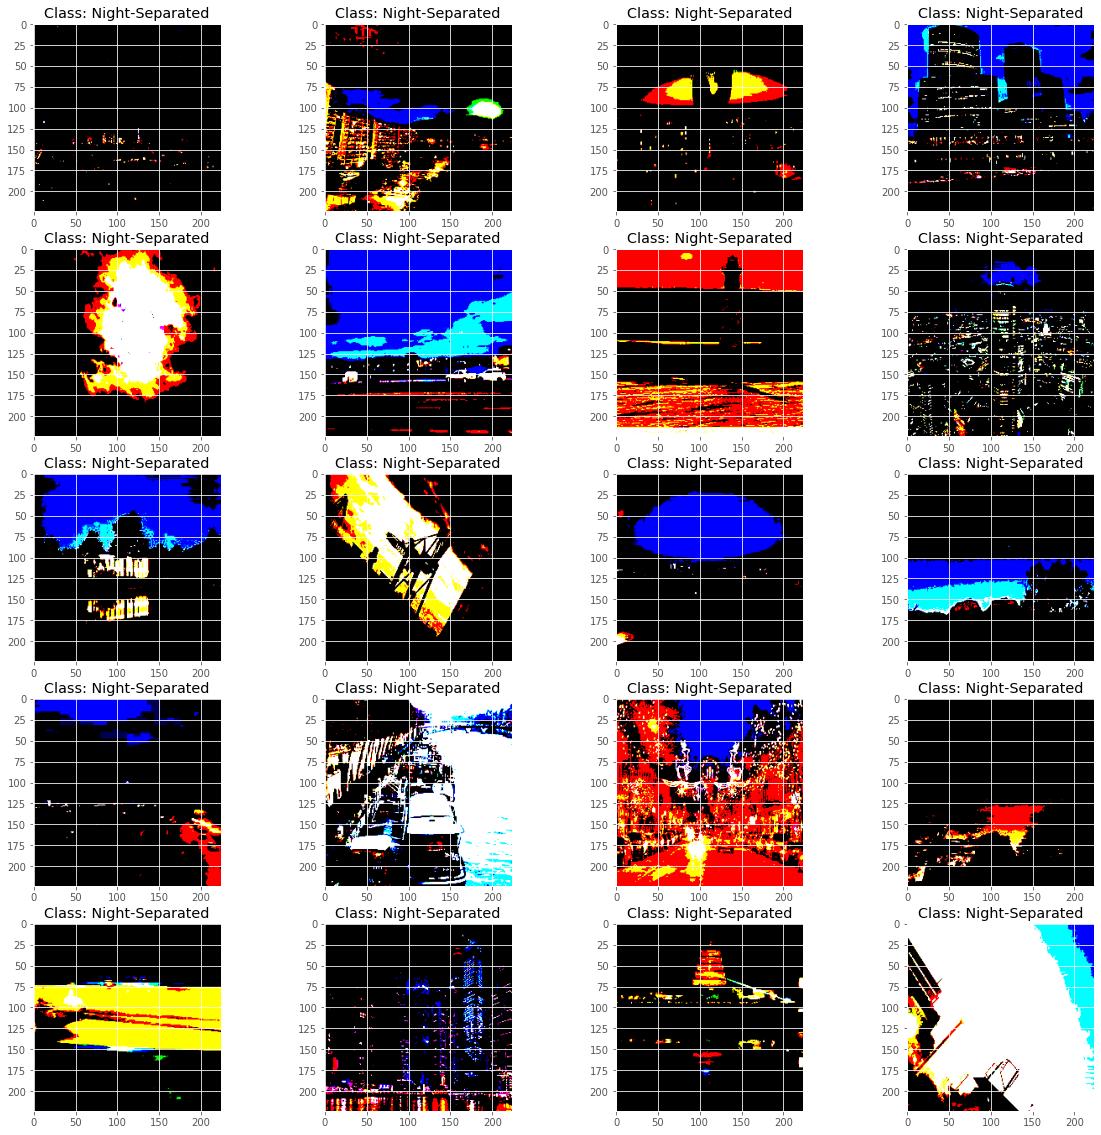

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_val[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + validation_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

In [ ]:
from keras.applications.resnet import ResNet101

# Define Model Architecture

In [ ]:
model = ResNet50(include_top=False, input_shape = (224,224,3), weights='imagenet')
for layer in model.layers:
  layer.trainable=False
flat = Flatten()(model.output)
hidden = Dense(1024, activation='relu')(flat)
outputs = Dense(4, activation='softmax')(hidden)
model = Model(inputs = model.inputs, outputs = outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Define Loss Function, Optimizator

In [ ]:
optimzer = keras.optimizers.Adam(lr = 0.000001)
model.compile( loss = 'categorical_crossentropy', optimizer = optimzer, metrics = [ 'accuracy' ] )

# Define Augmentator 

In [ ]:
checkpoint = ModelCheckpoint(     
                                'best_model_JLN.pt', monitor = 'val_accuracy',
                                verbose = 1, save_best_only = True, mode = 'max'
                               )

model.fit(
                    X_train,
                    train_targets,
                    validation_data = ( X_val, val_targets ),
                    epochs = 50,
                    callbacks = [ checkpoint ], 
                    batch_size = 10
                        )

Epoch 1/50
735/735 [==============================] - 57s 64ms/step - loss: 1.0426 - accuracy: 0.6540 - val_loss: 0.4978 - val_accuracy: 0.8210

Epoch 00001: val_accuracy improved from -inf to 0.82099, saving model to best_model_JLN.pt
INFO:tensorflow:Assets written to: best_model_JLN.pt/assets
Epoch 2/50
735/735 [==============================] - 46s 63ms/step - loss: 0.1962 - accuracy: 0.9408 - val_loss: 0.4346 - val_accuracy: 0.8472

Epoch 00002: val_accuracy improved from 0.82099 to 0.84722, saving model to best_model_JLN.pt
INFO:tensorflow:Assets written to: best_model_JLN.pt/assets
Epoch 3/50
735/735 [==============================] - 46s 63ms/step - loss: 0.0642 - accuracy: 0.9922 - val_loss: 0.4181 - val_accuracy: 0.8519

Epoch 00003: val_accuracy improved from 0.84722 to 0.85185, saving model to best_model_JLN.pt
INFO:tensorflow:Assets written to: best_model_JLN.pt/assets
Epoch 4/50
735/735 [==============================] - 46s 63ms/step - loss: 0.0277 - accuracy: 0.9984 - va

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict(X_val)

real_prediction = np.argmax(Y_pred, axis=1)
real_targets = np.argmax(val_targets, axis=1)

target_names = ['Day', 'Night-Not_Separated', 'Night-Separated', 'No_Sky']
# print(classification_report(Y_test, Y_pred, target_names=target_names))
print(classification_report(real_targets, real_prediction, target_names=target_names))

                     precision    recall  f1-score   support

                Day       0.90      0.94      0.92       495
Night-Not_Separated       0.82      0.79      0.80       133
    Night-Separated       0.76      0.66      0.70        99
             No_Sky       0.93      0.92      0.93       569

           accuracy                           0.90      1296
          macro avg       0.85      0.83      0.84      1296
       weighted avg       0.90      0.90      0.90      1296



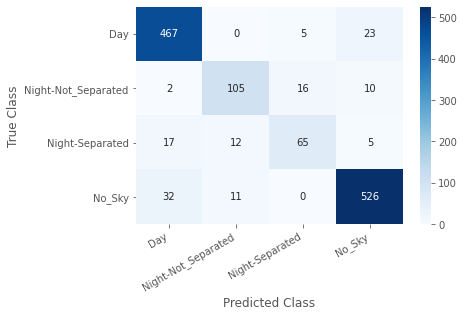

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_names=['Day', 'Night-Not_Separated', 'Night-Separated', 'No_Sky']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class');

cm = confusion_matrix(real_targets, real_prediction)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
reden = -1
for item in X_val:
  reden = reden +1
  if real_targets[reden] != real_prediction[reden]:
    print(validation_x[reden], real_targets[reden], real_prediction[reden])


/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_230.jpg 2 3
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_94.jpg 2 3
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_319.jpg 2 0
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_367.jpg 2 3
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_335.jpg 2 3
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_5.jpg 2 0
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_236.jpg 2 1
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_215.jpg 2 1
/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_371.jpg 2 0
/content/drive/MyDrive/edited_Jasmina_labeled_res

# Example :  
   Provide several examples of predictions along with softmax score probability

# Benchmark

In [ ]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    # istreniraniot model go koristime za prepoznavanje
    prediction = model.predict(image)
    # prepoznaenata klasa ni e indeksot od najgolemata vrednost vo izlezot (prediction), najgolemata verojatnost
    predicted_class = np.argmax(prediction)
    return target_names[predicted_class]

In [ ]:
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # PREPROCESS YOUR INPUT
  image_preprocessed = preprocess_input(cv2.resize(image, dsize = (224,224)))
  return image_preprocessed, image_

def predict_url(url):
  image_resized, image = url_to_image(url)
  predicted_class = get_prediction(image_resized)
  plt.imshow(image)
  plt.title("Предвидено : " + predicted_class)

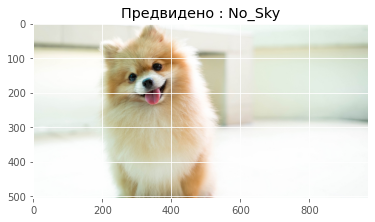

In [ ]:
predict_url("https://d17fnq9dkz9hgj.cloudfront.net/uploads/2018/04/Pomeranian_02.jpg")

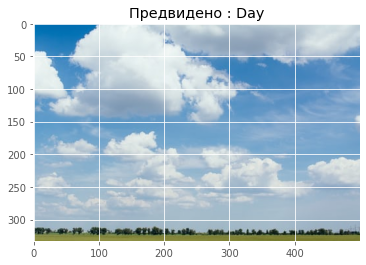

In [ ]:
predict_url("https://images.unsplash.com/photo-1463947628408-f8581a2f4aca?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxleHBsb3JlLWZlZWR8Mnx8fGVufDB8fHw%3D&auto=format&fit=crop&w=500&q=60")

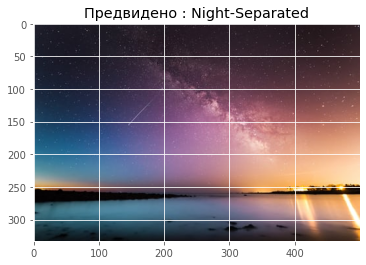

In [ ]:
predict_url("https://images.unsplash.com/photo-1468276311594-df7cb65d8df6?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxleHBsb3JlLWZlZWR8OXx8fGVufDB8fHw%3D&auto=format&fit=crop&w=500&q=60")

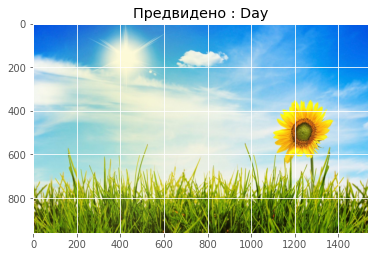

In [ ]:
predict_url("https://scontent.fskp2-1.fna.fbcdn.net/v/t31.0-8/p960x960/10945111_1532150797037312_5930509058927773875_o.jpg?_nc_cat=111&ccb=3&_nc_sid=e3f864&_nc_ohc=FfcA0O6r2LAAX_L3gIe&_nc_ht=scontent.fskp2-1.fna&tp=6&oh=6b433ef1607a363f79d6bff5242a6112&oe=604F3D3A")

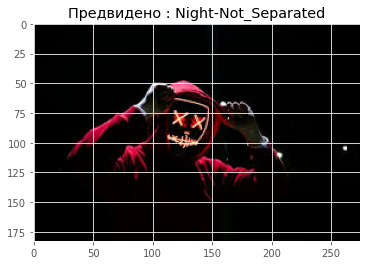

In [ ]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQDw8QDw8PEA8PDxAVEBAQEBAPERUVFRUXFxUWFRUZHSkiGBolGxcXIjEhJikrLi4yGCEzODMsOSgtLi0BCgoKDg0OGhAQFy0fICUtLS0tLSstLS8vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBEQACEQEDEQH/xAAbAAEAAgMBAQAAAAAAAAAAAAAAAQIDBAUGB//EADsQAAIBAwIDBgMGBAUFAAAAAAABAgMEERIhBTFBBhMiUWFxMoGRFEJSobHBFXKS0QcjM4LhJDRDYvD/xAAaAQEBAQEBAQEAAAAAAAAAAAAAAQIDBAUG/8QAMREBAAICAQMCBAQFBQEAAAAAAAECAxEhBBIxQVEFE2FxIiOB8BShscHhMlKR0fFC/9oADAMBAAIRAxEAPwD4aAAASAAAAgAAAAAAoEAoAAAGSHICsgKgCAAABQABAAAAAAAAAAAAASAABAAAAAAAAAAAAAAGSBYSVZhVQBAAAAAUAAQAAAAAAAAAASAAAAgAAAAAUCAAAAAAAL02VJRMKqQAAAAAABQABAAAAAAAAACQAAAEAAAAACgAIAAAAABaASSYVUAAAAAAAKAAIAAAAAAAAkAACAAAACgAAAABAAAAAALQBKZhIUCgAAAABQAAAgAAAAAAACQAAIAAoAAAAAAAEAAUAA0BFogkkVIVIoACgQABQAAAAQAAAAAEoAACAAKAAAAAAAAfReyPZWxp2P8AEeMKt3VeUoWlGD7vU4xb1SlzWpxajyW3XKLrUbI5lxqt9wWeV/Dr2j5SpX0JS9MqpTaM7XUOv2Z7HWFw3P7ZGvtB/Z1LuakFPLUZtpd5JYedGywNvodF0+HJOskzv2e3teB2lBYhb29PbGXGLk/eUstk2+9j6fFXitXC432Qs7j4Iwo1HylRcUv91POH8sMbcs/wzDljcR2z7vnPH+z9eynpqpOEvgqRzol6ej9GWJfnup6TJgtq0fq5KK8srSCQoFAAUCAAKAAAEASBAAAAAASACAAKAAAAAAA7PZTgzu7hRkpfZ6UXVuZr7tKG8t+je0V6yRYjaTOnW7Y9sqvEVToxhGjZ0MKjQgsJKK0xz7LoS1t8EQ8xQj5LLz15GZaiHQ4TXq0bijVopSqU6idNOOtSl5aevPl6mJmHox1tFomHY492l4l/5qdShH8M6Dhj5zRYiJ9X0MvxTNH+mO39HIp8fuOXfNp9KkITiO1zp8Tzf7/+Y4dS07RudOVK40qm448MFUpS3+/Tz4f5o4afmTx4emOunNTtzRGvfztxbvhyw50ZKpBfEovU4/o2vVpG4s+dm6T8Pfjnuj116OfI08EKYCgUCAAKAAAAABAAAAAAAAEgAgFAAAABKQHouz3Zb7S499dULOEknCVfW3JN48MYr6ZxkcPVHRZpx/M7eHt+1lxR4Xa/w3htPw3FOM695JqU6yecSTW2OeMbLfrk3b8MPHrc8vnCoaThMttV02n8+RdkL1nKHOT1fdxthefoI1Ph2t3VjmeWxadob2l/p3dxFfh72co/OLeH9CzSs+jEZb19Ww+0kp/9zbWdznnKVBUan9dFwf1yTs9pmF+bv/VESsv4dW5O4sZt821d0PyUakV/UPxx9SPlz44YryxqW0oSlOEoVE3RuLeeqEtPxYaxusrKaTWUZ3vw9Fd1t+OfPiYb3ZN2DvKcuJxk7dKTnCmpJTljw7Rw0vNLH6movwxbD3T7T/V0eIU+CSvJ0bWnV+zV5LTXq1KtOVvlYxGDzrWpZzLOVJLZ7mu5w7NRy5Tdjqk1aTzb7d2685QrLOluo0k4NPD8OE+W3MTKxWJa9ThcK9OrWs4zXcxc69CUlOUIdakJbaoJ4TWMrbmt1YnbEw4gQAAAAACAAAAAAAAAACQAEASAA6fCODyr6pN6KUOc8Zy/KK6skzp9DoPh2TqpnXER6vR8N7N0qVN3DqQuXF7Qimow9Zxe7f5e5nufX6P4TSlptlnumPRwuN8TdRtZzvu9xEPJ8T6+L/l08Q63BO0EaltO0ucycVKdtNbyU+q9n181vzSOvdHbqXxp/H93LqVoxWZPnyXX6Hn3MtRSI5swVbqEZfDqa/pLNZmNbdKdmO+5jemThFzF31GpWpRrQVWOui0tMoLnHD2e3T0JMRTHxw6R39T1MRrcz6PW8W/w7nK5qToSjTspJVlcVGoW9OlPxLxPy3WFl7I4U6mfEw9eX4fiivdFtTz+H14/s8fxe2tVc93ZVqlWh4IqrWiqeZcpSSXKGd1lZ9D1Radbs+XNIm/bRk492er2dxK3lHvJJx0zpqTjPPJx2zz2x5pkrlraN7dLdLlr/wDMzDYvqEqdhaQnGUZ/a7/VGScZJxjbxw0+TTTRnjumY+jrEfl1ifq0nR1U1j4o8vPBzi+rcvbfBN8MTXzH9GKjrcZOUH3euKlNRelTak4py6NpS29H5HeY43D5tbbtMW9VFjMkm879eefMOfiXR7OcVjQrTdTLo1KeirDSpxmtSemUXzWxqs6YnlzuLUacK01RlqpN5pvrpluk/Vcn7FRpgAAAAAAgAAAAAAAAAAASwM1ra1KstNOEpyfSKb+vkHTHivknVI29Lwvs9Tp+O7ak479zCXhSXPXJfovqZmX3+j+Caj5nU8R7MfEuPRy404qMOShBKMUumME1t1z/ABXFhj5eKOPo4tDiVWE9cZNZ2aT2a8mXUPiV67NW/fEtOUstvzbNPJM907WpycWpLmmmiEccr1ZZ588b/Pf9w1M7VnHDw+YLRqdOlwC4tqVyql3TqVaVNTkqVOShrml4Iyl0g3zxuYvEzXUOlb/Ly93t4ezu+2yv7GVKrKnb16FeP2elCOmk6U4tOCXLwOKeXvv6njv03bPjcPsdB1sd86nU2jU79/u8v2d4dO4unSpJTl1WpRTW+ZZeyS5/I65p/Lhz6Ltr1NrWnda+dev2/V9D43xShTsJXFpUpXd7w/uqc7jDlThGb0xqUk9qklLC1vbMnLG6OGLHM31Z06nqZrjtOOdUt49/1eB7STlixozk5VI23e1XJ5k6lzOVWWp+el0z111qZfOiJtatfp/Vz7ifdxjjmc6R3zO30epvPTY69vlZ1lUi4Rk1FyUnSy1FySazjk3htZ9TcRavl4ctsWbmvE+zSnavPI6xZ8+1ZidLU7dkmUUuqOEn5PD+fL9zVZJappAAAYACAAAAAAAAAAABKA6XCeHd63KbapR5+cn5L+5JfS6DoJ6i3dbiseXqqV7op91SjGnB/dgks+76mNv12CuPDWIxxEOBxzimf8qm9l8cl95+XsWH5/4t8Rm0/KxzxHmXCNPgAAECKN+hTSzUnuk8Ri/vS8vZdTG3spSKx32/9areW2+beSvPPM7l17nszdpwapOSq28biOlxbdJvGUur5PSsvDyYjLXXMuuTp79/HLRXD5wqyhWpVo91iVxFQaqQhmOW4vl8S543aN744cIrq34obvaiwoW1ZUqEqzaiu8jVUVKOpKUd4yaknFp5XmYxza0bs754pTUY9xPqt2XhOU6sZTlCz7uMr5rCzShOMtGfxSmoxWOba6ZLfUc+rGGLTOvTzLFe3kri5nWn8dWUpNLlFcoxXolhL2Oc8V09uGN5YmPMtTiFXVLC5R2/uaw11Dn8Sz/MyajxDTZ2fPZ6N3KLWXlevMzNYlqLc8unGSeHzRz+jVo1zAqUZS0yemEtnL8PlL2Tw36ZNV4c3Ov+H1qEtNalUpSe6U4OOV5xb+JeqOo1SABAEgQAAAAAAAAAASgOhwrh6qvM3ppR+J9fVIzMvo9B0P8AETNrTqseZbav450U1ppRzhc/r5k5e3H1tIn5ePisMN3xJpaYc3zf9iRXbHVfEpivZjco6PihBelSlKSjFOUm8JJZbLLVa2tMVrG5Z61hWg1GVKpGT5Jwll+3mR0t0+WsxE0nf2bn8MjRw7lzjJpSVKMd2vWT5euzMzb2eyOhjFqc86nzr/LUuq2t5wkltGK5JEhwzXm878R7Nc04S9nwb/ES/su5jCqqtvCnBKjVipRUVLdQfOLxlZ9Tj8mtonfl6c+XVomI4mIem4Vxixv41406FvC4uqsaMaFem1KUXPvJN1LdKWHohu4+Frdyycb47U09GLL839x/d0eM0OCTlNXdxbwWHU2qTrVMTjTjScIqCa/y6MHz21v0ZmvzfNVyXw9upiN8fve/7ej572xuLSjJWnDKveWvhnWqJSXeVt+r3cIrGF0blzPVji0xu/l4b3rHFI1DiUfBB1Hze0P3ZLcz2vZi/KxTmt68R/208/qdtPlTO52ipHGPWKZUhQK6PD/9Ob1x8MoJQedclLVlxWOS0rP8yMWr6ulJ3w2KMsyXhk1nfCZIhm0ae049eUlw37M6yuO/VCNJJNqhKEk9SlL7zSUGl0zvk9No1VMde++nzOS3OSSgAAAgAAAzW1rUqvTSpzqSSbcYRlN4XN4XQDFgCAAAABmtaDnJRTS6tvkkubZNumLHN7dsN65ulGn3cHs9vXHr7mIjc7l9LP1NceCMWOXNz5HR8qJmPCCABKA7PZr/AC6jrtbUoy0+Tk1y/pz+Ri86fZ+EY4jJOe3isfzetqcRhOEKkZtRafxNNxfXH9jM+H62uWl8fzIl5jj83UWXJqdJ7wctSxL70G+j22LV+X+Kz8z8W9Wr5j6e8ODqOmnw+4TC7S3nHoEtO4ZKNSdN6oTlCWJLVCTi8STjJZXRptP0Y8sxMx4YclRs21DPiltHPzfojna2uI8vZ0+CLT3X8fzlW7rub8ktkuiXoKU7YZ6rqJy2+kejEjbyJqPOPRY/NsEMZVWp5ysZznbHPJJarvfDNK6qLZzlt6sQtvaVe/njGp4fTJdpEzHh6/sp2YXGJKlSlSoXEYtuck1CaXRpcpdcpeeTG3rz1x3xRkpxPif+3muOcKqWlzWtqunvKE5QnpeVldU/I1t4YlzyqAQAAAd/sf2sueF1517Xu9c6bhJVYOcWm084TW6aXUkxscKUsv3fsUVAAAAF4VGk0uvMNRaY8KhAgAMAZ7Wnqktk8b6Xlav/AFz6iXbDSLW/fP0dO7v4zjBxgqfNSjH4VhYX5NfQxFeX0s/WVtSOyvb7xH2a8br/AKd088pRa9ns/wBh28ucdVMdNOLa1V97Rz9+lz83D/h/qyRxOlyz8/B3R5r5+3+HLZ0fKAGSiWyKmOwWJ15eo4RO3o+Kcs1sRlTk900+iXT3OW/o/UdB/DYY3kndpjjY7qhWqVI1bem6nSa1Qcl0zh8y7mI2kfwvUZr0yY4i0eNeq1xwa2lTWjNKtjZuTlCT8mny90Xua6n4Jgmn5U6n6y4V9ZVKccTpYUJSzUW+c4xv5bbe5uJ2/N5ujzYN99dfX0aOCvOtSm4yUlzi018hLVbTWYmCo222+befqRbTMztUMtzhnE6ttONSjNwnCcZRkm08x5chMNRaYjXunidR1Ks6jbl3rc8yblLxPLTb3bTys9efUM2rqeGiwgAKAEASAAgABIBYzvyAMCSKAQBKAyKWlNddg3uaxMLSq5Us820/mFm+4lNpT1Sx6foZtOodemx/Mv2lGs4zz7p+z2LrhMeWaZP+YlgK4SgqAQIoUbsFrov8VF5/2Pn9H+pnxL2UicmGfev9P8JqVGu7qr+WXuv+Ca403bLMWpnj7T94ZrniD1Rw3hbma193q6n4habx2zw6sOJKjCNOqtaqR3T3Wlrr7vJKxL6dutx4sUYc8b7o/kxWMqE8xhbJRim5Sfjn7Zf6C0z6uPQV6XJukYtxHmZ5Uq8Pt345ZpR5uEJJ7ejfX8hW8+rOX4d0s/mTPZHttx73RqzTTUHyTeWsep0jb4eeMfdvH4a5XACMkd1jy3/+/L6AlDSDKmQGSqgABAAAAAAAAEphUkAKAGE8gGS3rOEtS54a+pJjbtgzTiv3VY2yuU8zsYAIgqJIqCpLZsLhQnmScotNSWcbMlo29PS5oxX3aNxPEppSxKUH8MtvZ9GQpaNzj9J/cMLi9Wl808fsVx1q2pTVnmTbbflnfboGr2m1pm07bf2lQhGC/mnjbLfJe2DOty9sdT8rFXFH3n7+kNWpcSlnU85wXUQ8d81777p3tNacXGmksSjHEvXfK/UQ1lvS1axEcxHLCVwAqUwiuSoAAIAASAAgAAAAAAE5AkjQAAhgSgIAkABDQSYABSUxIsM1xHEvkmn5royQ6ZI7bcMLZXOQIZCgEBAKkABGSsmQGQIAAAAAAAAAAAACUBKI1AAAICAAEgAGAaAAGaM046ZdPhfl6ewbi0TXtn9GFhzQBIUAAAIyEMlRAAAAAAAAAAAAAAAAAAAsRQKAAICJCgAAAAASgkpaCbUyUMgMgQAAAAAAAAAAAAAAAAAAAAABZEWAKAAICJCgAAAAATEJKZBljKoAAAAAAAAAAAAAAAAAAAAAAAAWRFgCgAAAAAAAAAAQZlZhFCqgAAAAAAAAAAAAAAAAAAAAAAAAlEWEgAoAAAAAQABQBEMrsIxlUABAKBAKAAIAAAAAAB//2Q==")

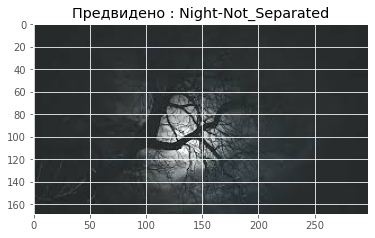

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTal6nSKLhNL8KkKlHf4uv_PbknncdEKST0qQ&usqp=CAU")

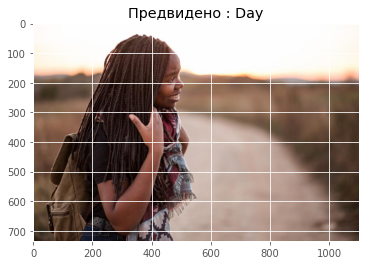

In [59]:
predict_url("https://cdn-prod.medicalnewstoday.com/content/images/articles/326/326378/a-woman-out-for-a-hike-wondering-if-black-people-can-get-sunburned.jpg")

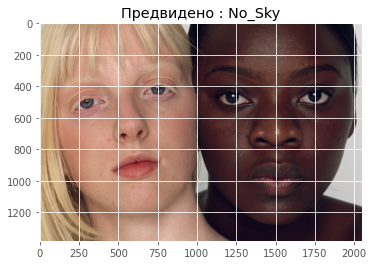

In [60]:
predict_url("https://www.nationalgeographic.com/content/dam/news/photos/000/774/77403.jpg")

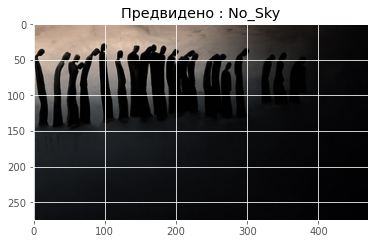

In [61]:
predict_url("https://www.markmallett.com/blog/wp-content/uploads/2015/03/people-walking-in-dark.jpg")

# Summary about your results